# GitOps Flow with MLRun

In [1]:
from src import create_and_set_project

### Setup Project

In [2]:
# ENV_FILE = "mlrun.env" # update to your .env file

In [3]:
project = create_and_set_project(git_source="v3io:///bigdata/ghactions.zip")

> 2023-06-30 02:45:23,400 [info] loaded project gitops-flow from MLRun DB


### Run Training Pipeline

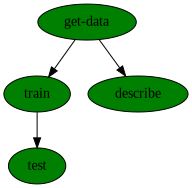

uid,start,state,name,parameters,results
...4688a2ee,Jun 30 01:04:56,completed,test,label_column=labelnew_model_path=store://artifacts/gitops-flow/model:c619156f-c9fc-4087-b4c8-9f112e512d4aexisting_model_path=Nonecomparison_metric=accuracypost_github=Trueforce_deploy=False,accuracy-new_model=1.0test-error-new_model=0.0f1-new_model=1.0precision-new_model=1.0recall-new_model=1.0
...3b85fd25,Jun 30 01:04:36,completed,describe,label_column=label,
...7c424525,Jun 30 01:04:36,completed,train,label_column=labeltest_size=0.1,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0
...536a3f3e,Jun 30 01:04:10,completed,get-data,,num_rows=150


In [4]:
run_id = project.run(name="train", dirty=True, watch=True)

### Run Deployment Pipeline

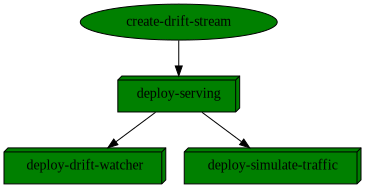

uid,start,state,name,parameters,results
...ac5aeab2,Jun 30 02:45:36,completed,create-drift-stream,stream_path=pipelines/gitops-flow/model-endpoints/log_stream,


In [4]:
run_id = project.run(
    name="deploy",
    arguments={"model_path": "store://models/gitops-flow/model#0:latest"},
    dirty=True,
    watch=True
)

### Invoke Model

In [9]:
serving_fn = project.get_function("serving")
serving_fn.invoke('/v2/models/model/infer', {"inputs" : [[6.1, 2.8, 4.7, 1.2], [5.7, 3.8, 1.7, 0.3], [7.7, 2.6, 6.9, 2.3]]})

> 2023-06-30 02:55:50,468 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-gitops-flow-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': '1fbbf92a-76e7-4dbe-a2fc-cc0778cdceb7',
 'model_name': 'model',
 'outputs': [1, 0, 2]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [27]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = "model"

# Get test set
df = project.get_artifact("train_test_set").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
iris_data = df.drop("label", axis=1).to_dict(orient="split")["data"]
iris_data[:5]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,label
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


[[6.1, 2.8, 4.7, 1.2],
 [5.7, 3.8, 1.7, 0.3],
 [7.7, 2.6, 6.9, 2.3],
 [6.0, 2.9, 4.5, 1.5],
 [6.8, 2.8, 4.8, 1.4]]

In [28]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(12_000)):
    data_point = choice(iris_data)
    serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

  0%|          | 0/12000 [00:00<?, ?it/s]

### Simulate Drift Event

In [5]:
import json
import v3io.dataplane

In [6]:
v3io_client = v3io.dataplane.Client()

In [7]:
drift_event = {'endpoint_id': '364ccdd1c2f6627ddfb523b16f53ae2b62e56ee8', 'drift_status': 'POSSIBLE_DRIFT', 'drift_measure': 0.87}

In [8]:
v3io_client.stream.put_records(
    container='users',
    stream_path=f"pipelines/{project.name}/model-endpoints/log_stream",
    records=[{'data': json.dumps(drift_event), 'shard_id': 0}]
)